In [58]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from random import random
import seaborn as sns
import itertools
import numpy as np
import re

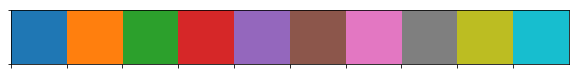

In [59]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

### Function definitions here: 

In [60]:
def discretize_q_values(row, col_q_val):
    q_val = row[col_q_val]
    if q_val < 0.01:
        q_val_d = 3
    elif q_val < 0.05:
        q_val_d = 2
    else:
        q_val_d = 1
    return q_val_d


def unknown_essential_xy(col_screen, df_qval, df_annot, rand_param = 0.85):

    # col_screen = 'zhang_wt_mouse_d45_vs_zhang_input_library'
    df_qval_screen = df_qval[['Rv_ID', col_screen]].copy()

    # Discretize q-values: 
    df_qval_screen['q_val_D'] = df_qval_screen.apply(discretize_q_values, 1, args=[col_screen])

    # Merge with unknowns: 
    df_vis = df_qval_screen.merge(df_annot, on = ['Rv_ID'], how = 'inner')

    # Get x-y datasets: 
    rv_ids = df_vis.Rv_ID.values
    annot_list = np.array(df_vis.Annotation)
    q_list = np.array(df_vis.q_val_D)

    # randomize: 
    annot_rd = np.array([annot + rand_param*random()-rand_param/2 for annot in annot_list])
    q_rd = np.array([q + rand_param*random()-rand_param/2 for q in q_list])

    # color the unknown-essentials differently: 
    current_palette = sns.color_palette()
    # all genes are gray by default. 
    color_list = np.array([(0.85,0.85,0.85)]*df_vis.shape[0])
    # Unknown essentials in a different color. 
    
    ind_temp = list(df_vis[(df_vis.q_val_D.values >= 2) & (df_vis.Annotation.values <=3 )].index)
    color_list[ind_temp] = current_palette[0]
    
    return annot_rd, q_rd, color_list, rv_ids, ind_temp

### Load annotation score data: 

In [35]:
# file_uk = '../../data/annotations/unknown_essentials/unknown_ALL_levels_essential_scores.csv'
# df_uk = pd.read_csv(file_uk)
# df_uk = df_uk[['Rv_ID', 'gene_name', 'UK_score_4']]
# df_uk.head(1)

### Substitute with UniProt annotation scores: 

In [4]:
## get annotation according to UniProt:
file_UNP = '../../data/annotations/uniprot_Mtb.tab'
df_UNP = pd.read_csv(file_UNP, sep='\t')
df_UNP = df_UNP[['Entry', 'Gene names']]

file_UNP_2 = '../../data/annotations/UP000001584.csv'
df_UNP_2 = pd.read_csv(file_UNP_2, sep='\t')
df_UNP_2 = df_UNP_2[['Entry', 'Annotation']]
df_UNP = df_UNP.merge(df_UNP_2, how = 'inner', on = 'Entry')

rvid = [re.findall('Rv\d\d\d\d[a-zA-Z]?', gn)[0] for gn in df_UNP['Gene names']]
df_UNP['Rv_ID'] = rvid
df_UNP = df_UNP[['Entry', 'Rv_ID', 'Annotation']]
df_UNP['Annotation'] = [int(a.strip()[0]) for a in df_UNP.Annotation]

df_UNP = df_UNP[['Rv_ID', 'Annotation']]
df_UNP = df_UNP.sort_values(by = 'Rv_ID').reset_index(drop=True)

file_out = '../../data/annotations/uniprot_annotation_scores.csv'
df_UNP.to_csv(file_out, index = False)

# df_w_annot = df.merge(df_UNP, how = 'inner', on = 'Rv_ID')
# df_w_annot['Gene name'].fillna('', inplace=True)

In [61]:
file_annotation = '../../data/annotations/uniprot_annotation_scores.csv'
df_UNP = pd.read_csv(file_annotation)

#### Just out of curiosity...

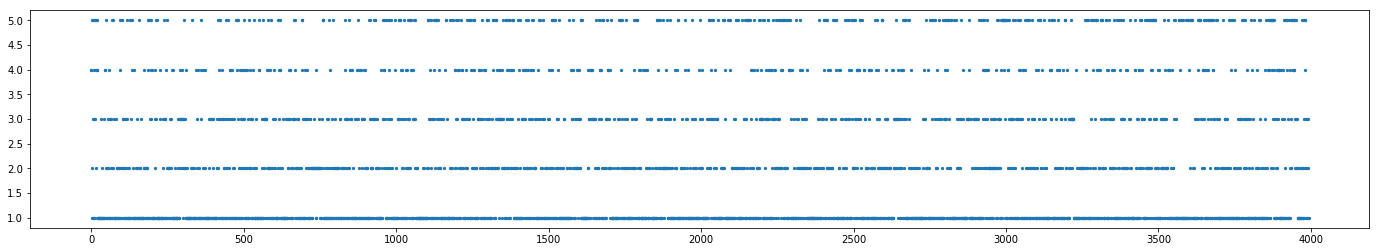

In [6]:
plt.figure(figsize=(24,4))
plt.scatter(np.arange(df_UNP.shape[0]), df_UNP.Annotation, s=5)

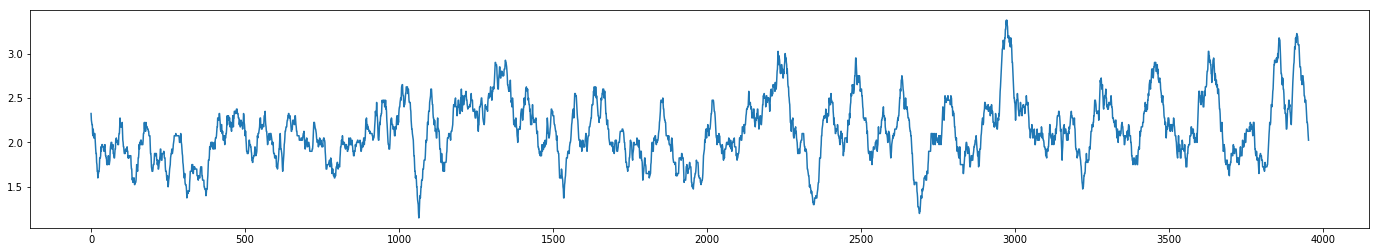

In [37]:
window_size = 40
list_annot_mean = []
for i in range(df_UNP.shape[0]-window_size):
    inds = np.arange(i, i+window_size)
    annot_mean = df_UNP.iloc[inds].Annotation.mean()
    list_annot_mean.append(annot_mean)

plt.figure(figsize=(24,4))
plt.plot(range(df_UNP.shape[0]-window_size), list_annot_mean)

In [53]:
max_ind = [i for i in range(len(list_annot_mean)) if list_annot_mean[i] == max(list_annot_mean)][0]

In [56]:
df_UNP.iloc[np.arange(max_ind-2,max_ind+50)].tail(40)

,Rv_ID,Annotation
2981,Rv2923c,1
2982,Rv2924c,5
2983,Rv2925c,4
2984,Rv2926c,1
2985,Rv2927c,1
2986,Rv2928,5
2987,Rv2929,1
2988,Rv2930,5
2989,Rv2931,5
2990,Rv2932,5


### Load log2FC and q-value dataset: 

In [62]:
file_log2FC = '../../data/standardized_data/result_logfc_matrix_2020_08_27.csv'
df_log2FC = pd.read_csv(file_log2FC)

file_qval = '../../data/standardized_data/result_qval_matrix_2020_08_27.csv'
df_qval = pd.read_csv(file_qval)

### CRISPRi and SDR annotations: 

In [ ]:
file_umap = '/Users/ajinich/Documents/git_repos/tbredox/data/df_umap.csv'
df_sdr_CRISPRi = pd.read_csv(file_umap)

## Show the genes in the CRISPRi library:

file_crispri = '/Users/ajinich/Documents/git_repos/tbredox/data/cloned_genes.xlsx'
df_crispri = pd.read_excel(file_crispri)
df_crispri.rename(columns = {'gene\nname':'gene_name'}, inplace=True)
df_crispri['gene_name'].fillna('', inplace=True)

df_crispri = df_crispri[df_crispri.gene_name.str.contains('Rv')].copy()
df_crispri = df_crispri[df_crispri.ID.values<=74].copy()

df_crispri['Rv_ID'] = [''.join(gn.split('_')) for gn in df_crispri.gene_name]
df_crispri = df_crispri[['ID', 'Rv_ID']]
df_crispri.reset_index(inplace=True, drop=True)

df_sdr_CRISPRi['CRISPRi'] = df_sdr_CRISPRi.Rv_ID.isin(df_crispri.Rv_ID)
df_sdr_CRISPRi = df_sdr_CRISPRi[['Rv_ID', 'Gene name', 'is_sdr', 'CRISPRi']]

### Unit test for a single TnSeq screen: 

In [49]:
col_screen = 'dejesus_H37Rv_day32_vs_dejesus_H37Rv_day0'
annot_rd, q_rd, color_list, rv_ids, ind_temp = unknown_essential_xy(col_screen, df_qval, df_UNP, rand_param = 0.85)

### (INTERMISSION): how many SDRs are here? How many from our CRISPRi library? 

Orphan SDRs that are essential in mouse: 

In [40]:
df_sdr_CRISPRi[ (df_sdr_CRISPRi.Rv_ID.isin(rv_ids[ind_temp])) & (df_sdr_CRISPRi.is_sdr.values==1)]

,Rv_ID,Gene name,is_sdr,CRISPRi
247,Rv0242c,fabG4,1.0,False
873,Rv0851c,Rv0851c,1.0,False
1580,Rv1544,Rv1544,1.0,False
3130,Rv3057c,Rv3057c,1.0,False
3585,Rv3502c,Rv3502c,1.0,True
3632,Rv3549c,Rv3549c,1.0,False


In [45]:
df_sdr_CRISPRi[ (df_sdr_CRISPRi.Rv_ID.isin(rv_ids[ind_temp])) & (df_sdr_CRISPRi.is_sdr.values==1)]

,Rv_ID,Gene name,is_sdr,CRISPRi
247,Rv0242c,fabG4,1.0,False
1580,Rv1544,Rv1544,1.0,False
3130,Rv3057c,Rv3057c,1.0,False
3585,Rv3502c,Rv3502c,1.0,True
3642,Rv3559c,Rv3559c,1.0,False


Orphan genes in our CRISPRi library that are essential in mouse: 

In [48]:
df_CRISPRi_Zhang = df_sdr_CRISPRi[ (df_sdr_CRISPRi.Rv_ID.isin(rv_ids[ind_temp])) & (df_sdr_CRISPRi.CRISPRi.values==True)]

In [50]:
df_CRISPRi_DeJesus = df_sdr_CRISPRi[ (df_sdr_CRISPRi.Rv_ID.isin(rv_ids[ind_temp])) & (df_sdr_CRISPRi.CRISPRi.values==True)]

In [56]:
df_CRISPRi_CEs_invivo = df_CRISPRi_Zhang.merge(df_CRISPRi_DeJesus, on = 'Rv_ID', how = 'outer').sort_values(by='Rv_ID').reset_index(drop=True)
file_out = '/Users/ajinich/Documents/git_repos/tbredox/data/CRISPRi_CEs_invivo.csv'
df_CRISPRi_CEs_invivo.to_csv(file_out, index = False)

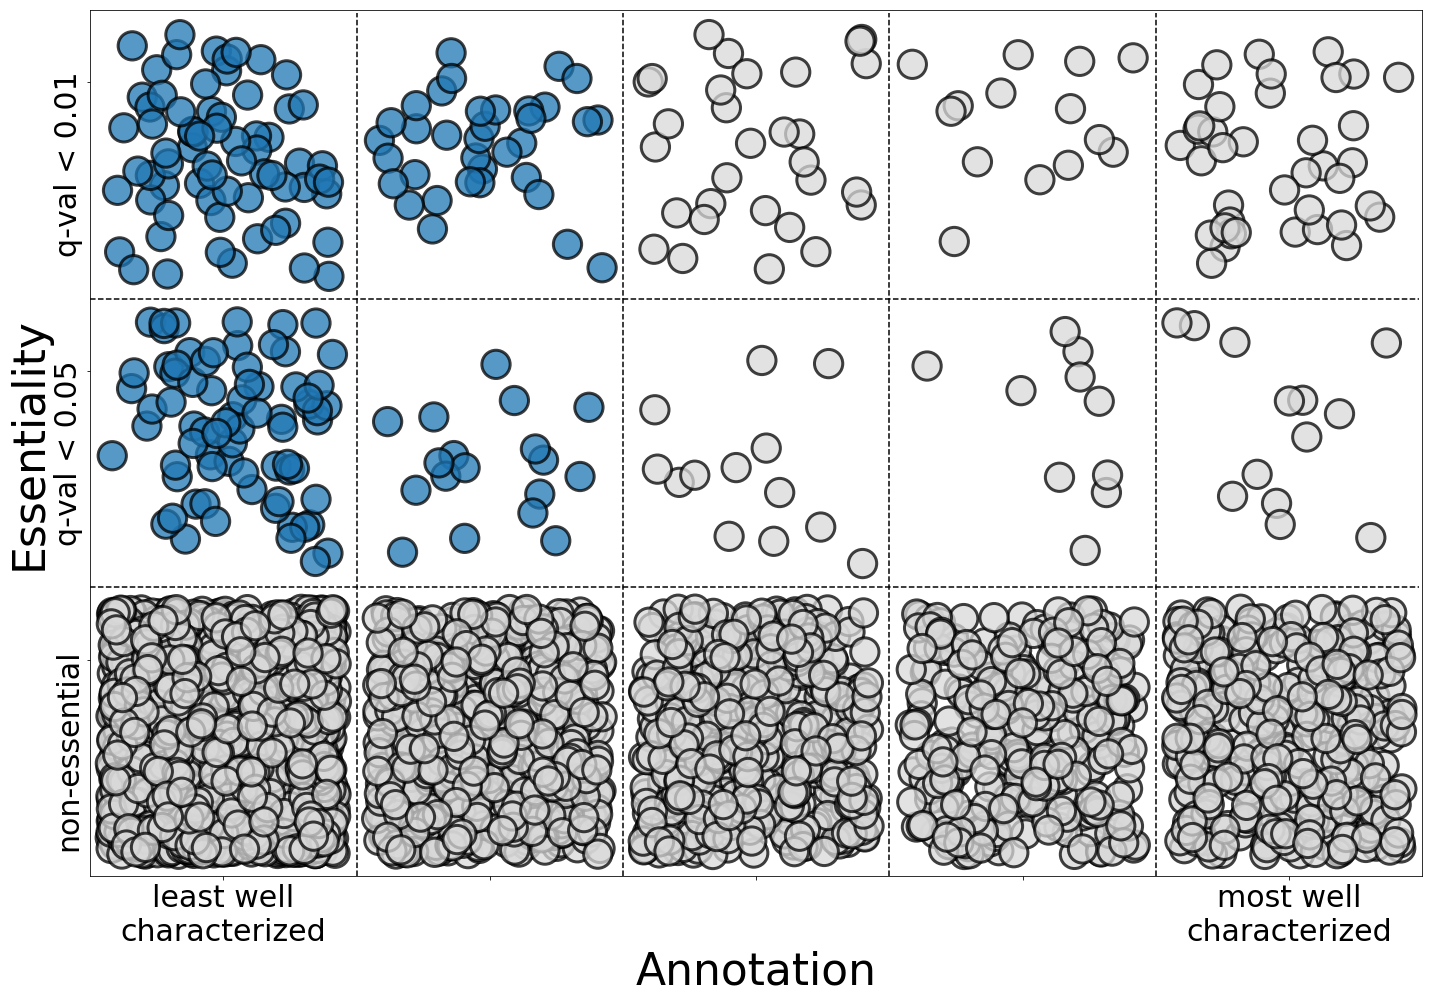

In [51]:
plt.figure(figsize = (20,14))

plt.scatter(annot_rd, q_rd, s = 800, edgecolors='k', alpha = 0.75, color = color_list, linewidths=3)

plt.xlabel('Annotation', fontsize = 44)
plt.ylabel('Essentiality', fontsize = 44)
plt.xticks([1, 2, 3, 4, 5], ['least well\ncharacterized','' , '', '', 'most well\ncharacterized'], fontsize = 30)
plt.yticks([1.25, 2.25, 3.25], ['non-essential' ,'q-val < 0.05', 'q-val < 0.01'], fontsize = 30, rotation = 90)

for x in np.arange(1.5, 5.5, 1):
    yvals = np.arange(0.5, 3.5, 0.01)
    xvals = len(yvals)*[x]
    plt.plot(xvals, yvals, '--', color = "k")
    
for y in np.arange(1.5, 3.5, 1):
    xvals = np.arange(0.5, 5.5, 0.01)
    yvals = len(xvals)*[y]
    plt.plot(xvals, yvals, '--', color = "k")
    
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 3.5)

plt.tight_layout()

# file_fig = '../../figures/genome_visualizations/unknown_essentials_090720.png'
# plt.savefig(file_fig, dpi = 200)

### Alternative plot (12/15/2020)

In [63]:
col_screen = 'dejesus_H37Rv_day32_vs_dejesus_H37Rv_day0'

df_qval_screen = df_qval[['Rv_ID', col_screen]].copy()
# Discretize q-values: 
df_qval_screen['q_val_D'] = df_qval_screen.apply(discretize_q_values, 1, args=[col_screen])
# Merge with unknowns: 
df_vis = df_qval_screen.merge(df_UNP, on = ['Rv_ID'], how = 'inner')

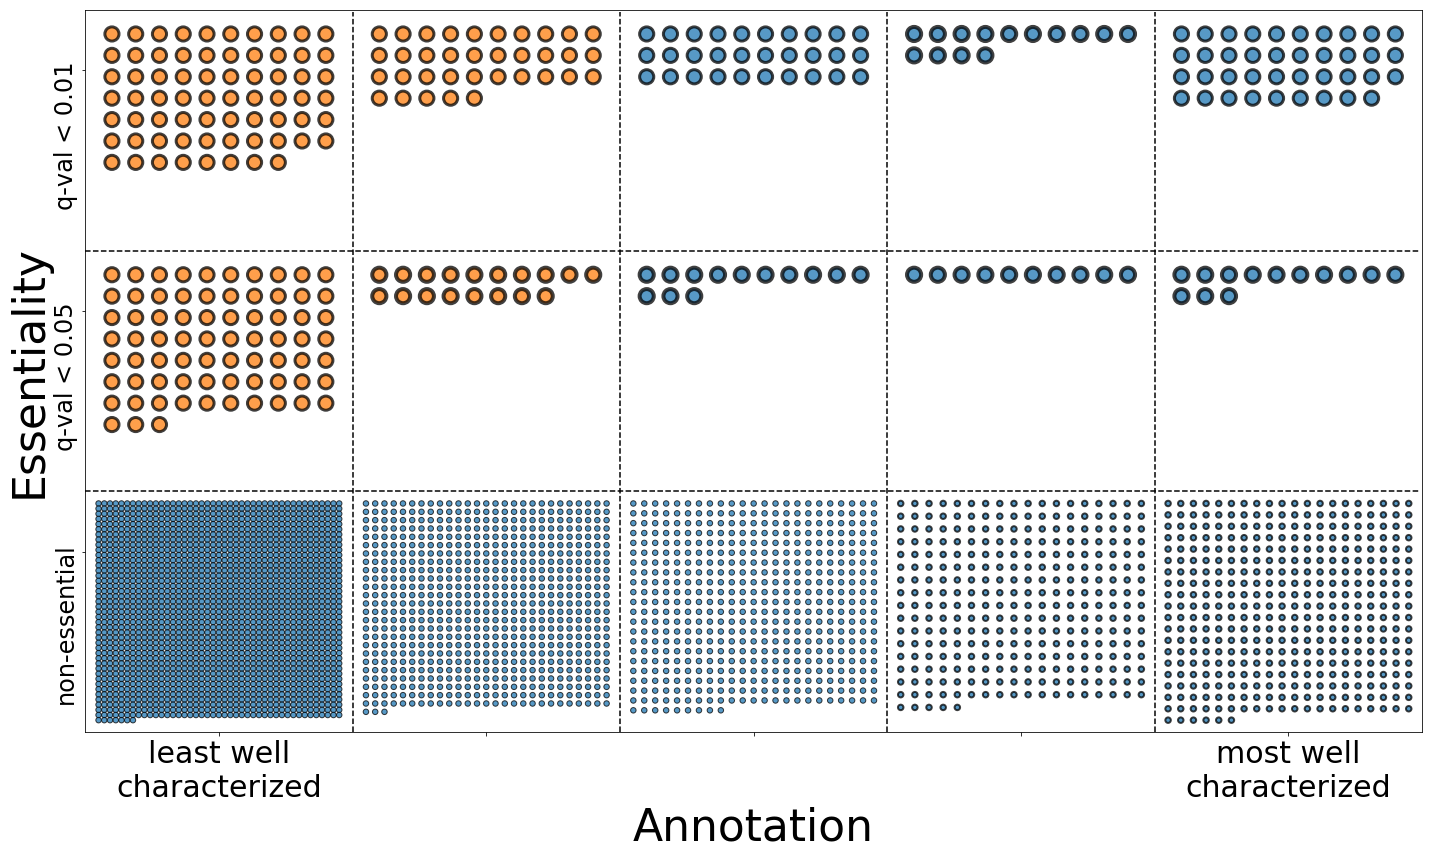

In [71]:
plt.figure(figsize = (20, 12))

for x in np.arange(1.5, 5.5, 1):
    yvals = np.arange(0.5, 3.5, 0.01)
    xvals = len(yvals)*[x]
    plt.plot(xvals, yvals, '--', color = "k")
    
for y in np.arange(1.5, 3.5, 1):
    xvals = np.arange(0.5, 5.5, 0.01)
    yvals = len(xvals)*[y]
    plt.plot(xvals, yvals, '--', color = "k")
    
rv_id_list = []
x_coords_list = []
y_coords_list = []
color_list = []
scatter_size_list = []
lw_list = []

for ann in [1, 2, 3, 4, 5]:
    for qq in [1,2,3]:
    
        df = df_vis[(df_vis.q_val_D.values == qq) & (df_vis.Annotation.values == ann)]
        rv_id_list.append( list(df.Rv_ID.values) )
        
        if df.shape[0] < 30:
            scatter_size = 200
            edge_param = 0.40
            lw=4
        elif df.shape[0] < 100:
            scatter_size = 200
            edge_param = 0.40
            lw=3
        elif df.shape[0] < 200:
            scatter_size = 30
            edge_param = 0.45
            lw=2
        elif df.shape[0] < 400:
            scatter_size = 30
            edge_param = 0.45
            lw=2
        else:
            scatter_size = 30
            edge_param = 0.45
            lw=1
          
        scatter_size_list += [scatter_size]*df.shape[0]
        lw_list += [lw]*df.shape[0]
        
        if ann <=2 and qq >= 2:
            color_temp = current_palette[1]
        else:
            color_temp = current_palette[0]
         
        
        color_list+=[color_temp]*df.shape[0]
        
        num_sqrs = np.max([int(np.ceil(np.sqrt(df.shape[0]))), 10])
        
        xrange = np.linspace(ann-edge_param, ann+edge_param, num_sqrs)
        yrange = np.linspace(qq+edge_param, qq-edge_param, num_sqrs)
        
        coords = list(itertools.product(yrange, xrange))
        coords = coords[:df.shape[0]]
        x_coords = [c[1] for c in coords]
        y_coords = [c[0] for c in coords]
        x_coords_list += x_coords
        y_coords_list += y_coords

        
plt.scatter(x_coords_list, y_coords_list, c = color_list, s = scatter_size_list, edgecolors='k', linewidths=lw_list, alpha = 0.75)

plt.xlabel('Annotation', fontsize = 44)
plt.ylabel('Essentiality', fontsize = 44)
plt.xticks([1, 2, 3, 4, 5], ['least well\ncharacterized','' , '', '', 'most well\ncharacterized'], fontsize = 30)
plt.yticks([1.25, 2.25, 3.25], ['non-essential' ,'q-val < 0.05', 'q-val < 0.01'], fontsize = 24, rotation = 90)
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 3.5)
plt.tight_layout()

file_fig = '../../figures/genome_visualizations/unknown_essentials_121520.png'
plt.savefig(file_fig, dpi = 200)


#### Adapting this to Anisha's dash code:

Here's an updated version: 

In [12]:
def unknown_essential_xy(df_vis):
    
#     df_vis = selected_data.dropna(subset=['Annotation'])
#     df_vis = df_vis.reset_index(drop=True)

    # NO MORE RANDOMIZATION! Instead this: 
    rv_id_list = []
    x_coords_list = []
    y_coords_list = []
    color_list = []
    scatter_size_list = []
    lw_list = []

    for ann in [1, 2, 3, 4, 5]:
        for qq in [1,2,3]:

            df = df_vis[(df_vis.q_val_D.values == qq) & (df_vis.Annotation.values == ann)]
            # update rv_id list
            rv_id_list.append( list(df.Rv_ID.values) )

            if df.shape[0] < 30:
                scatter_size = 200
                edge_param = 0.40
                lw=4
            elif df.shape[0] < 100:
                scatter_size = 200
                edge_param = 0.40
                lw=3
            elif df.shape[0] < 200:
                scatter_size = 30
                edge_param = 0.45
                lw=2
            elif df.shape[0] < 400:
                scatter_size = 30
                edge_param = 0.45
                lw=2
            else:
                scatter_size = 30
                edge_param = 0.45
                lw=1

            # Update scatter marker size
            scatter_size_list += [scatter_size]*df.shape[0]
            # Update line-width size
            lw_list += [lw]*df.shape[0]

            if ann <=2 and qq >= 2:
                color_temp = '#2b7bba'
            else:
                color_temp = '#585858'

            # update color_list
            color_list+=[color_temp]*df.shape[0]

            num_sqrs = int(np.ceil(np.sqrt(df.shape[0])))

            xrange = np.linspace(ann-edge_param, ann+edge_param, num_sqrs)
            yrange = np.linspace(qq+edge_param, qq-edge_param, num_sqrs)

            coords = list(itertools.product(yrange, xrange))
            coords = coords[:df.shape[0]]
            x_coords = [c[1] for c in coords]
            y_coords = [c[0] for c in coords]
            # update coordinates
            x_coords_list += x_coords
            y_coords_list += y_coords
    
    return x_coords_list, y_coords_list, color_list, rv_id_list, scatter_size_list, lw_list

In [13]:
col_screen = 'dejesus_H37Rv_day32_vs_dejesus_H37Rv_day0'

df_qval_screen = df_qval[['Rv_ID', col_screen]].copy()
# Discretize q-values: 
df_qval_screen['q_val_D'] = df_qval_screen.apply(discretize_q_values, 1, args=[col_screen])
# Merge with unknowns: 
df_vis = df_qval_screen.merge(df_UNP, on = ['Rv_ID'], how = 'inner')

In [14]:
x_coords_list, y_coords_list, color_list, rv_id_list, scatter_size_list, lw_list = unknown_essential_xy(df_vis)

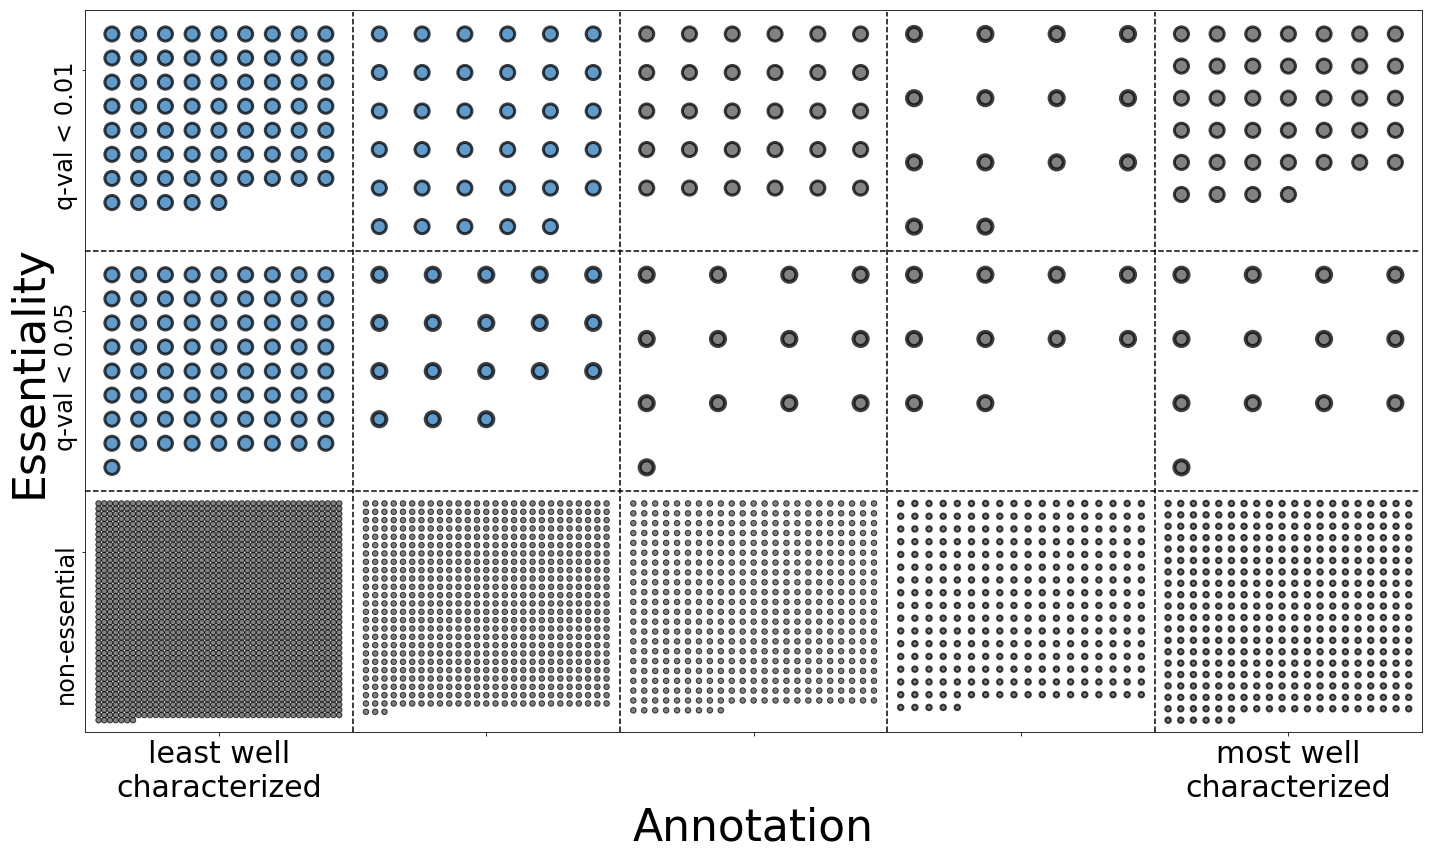

In [17]:
plt.figure(figsize = (20, 12))

for x in np.arange(1.5, 5.5, 1):
    yvals = np.arange(0.5, 3.5, 0.01)
    xvals = len(yvals)*[x]
    plt.plot(xvals, yvals, '--', color = "k")
    
for y in np.arange(1.5, 3.5, 1):
    xvals = np.arange(0.5, 5.5, 0.01)
    yvals = len(xvals)*[y]
    plt.plot(xvals, yvals, '--', color = "k")
    
plt.scatter(x_coords_list, y_coords_list, c = color_list, s = scatter_size_list, edgecolors='k', linewidths=lw_list, alpha = 0.75)

plt.xlabel('Annotation', fontsize = 44)
plt.ylabel('Essentiality', fontsize = 44)
plt.xticks([1, 2, 3, 4, 5], ['least well\ncharacterized','' , '', '', 'most well\ncharacterized'], fontsize = 30)
plt.yticks([1.25, 2.25, 3.25], ['non-essential' ,'q-val < 0.05', 'q-val < 0.01'], fontsize = 24, rotation = 90)
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 3.5)
plt.tight_layout()

## For every screen, count the number of unknown essentials:  

I don't think this is working anymore: 

In [72]:
# list_num_uk_ES = []
# for col_screen in df_qval.columns[1:]:
#     uk_rd, q_rd, color_list, rv_ids, ind_temp = unknown_essential_xy(col_screen, df_qval, df_UNP, rand_param = 0.85)
#     list_num_uk_ES.append(len(ind_temp))
# df_num_uk_ES = pd.DataFrame()
# df_num_uk_ES['screen'] = df_qval.columns[1:]
# df_num_uk_ES['num_unknown_ES'] = list_num_uk_ES


In [79]:
list_num_uk_ES = []
qq = 3
ann = 1

for col_screen in df_qval.columns[1:]:

    df_qval_screen = df_qval[['Rv_ID', col_screen]].copy()
    # Discretize q-values: 
    df_qval_screen['q_val_D'] = df_qval_screen.apply(discretize_q_values, 1, args=[col_screen])
    # Merge with unknowns: 
    df_vis = df_qval_screen.merge(df_UNP, on = ['Rv_ID'], how = 'inner')
    df = df_vis[(df_vis.q_val_D.values == qq) & (df_vis.Annotation.values == ann)]
    list_num_uk_ES.append(df.shape[0])

df_num_uk_ES = pd.DataFrame()
df_num_uk_ES['screen'] = df_qval.columns[1:]
df_num_uk_ES['num_unknown_ES'] = list_num_uk_ES
    

In [80]:
df_num_uk_ES.sort_values(by = 'num_unknown_ES', ascending = False, inplace = True)
df_num_uk_ES.reset_index(drop=True, inplace = True)

In [81]:
df_num_uk_ES.head(20)

,screen,num_unknown_ES
0,dejesus_Rv1432_day0_vs_dejesus_H37Rv_day0,106
1,marP_KO_vs_marP_WT,74
2,dejesus_H37Rv_day32_vs_dejesus_H37Rv_day0,68
3,zhang_wt_mouse_d45_vs_zhang_input_library,67
4,ritterhaus_hypoxia_H6_vs_ritterhaus_hypoxia_input,59
5,dejesus_Rv1565c_day32_vs_dejesus_H37Rv_day32,50
6,xu_inh_025_vs_xu_inh_0,41
7,dejesus_Rv1565c_day0_vs_dejesus_H37Rv_day0,35
8,minato_minimal_plate_vs_minato_rich_plate,31
9,zhang_wt_mouse_d10_vs_zhang_input_library,30


Text(0, 0.5, 'number of screens')

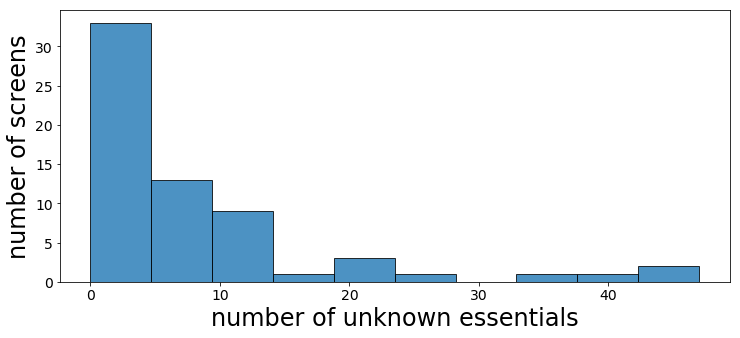

In [40]:
plt.figure(figsize=(12,5))
hst=plt.hist(df_num_uk_ES.num_unknown_ES, color = current_palette[0], edgecolor='k', alpha = 0.8)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('number of unknown essentials', fontsize = 24)
plt.ylabel('number of screens', fontsize = 24)